In [4]:
import catboost
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import time
import xgboost as xgb

from catboost import Pool, CatBoostRegressor, cv
from itertools import product, chain
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.pylab import rcParams
from mlxtend.preprocessing import DenseTransformer

from sklearn.datasets import load_boston
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer, LabelEncoder

from paramsearch import paramsearch
import util
reload(util)
from util import plot_top_features, crossvaltest, catboost_param_tune

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 


# matplotlib settings
matplotlib.style.use('ggplot')
rcParams['figure.figsize'] = 12, 8
rcParams['font.size'] = 12
rcParams['axes.facecolor'] = 'white'

In [2]:
# ! pip install jupyternotify
%load_ext jupyternotify

<IPython.core.display.Javascript object>

In [3]:
n_time = 3
n_folds = 5

In [50]:
dataset = load_boston()
df_train = pd.DataFrame(dataset.data, columns=dataset.feature_names)
y_train = np.log1p(pd.Series(dataset.target))

In [41]:
cat_indices = [3]
train_pool = Pool(df_train, y_train, cat_features=cat_indices)

In [42]:
params = {'loss_function': 'RMSE', 'custom_metric': 'RMSE', 
          'eval_metric': 'RMSE', 'logging_level': 'Silent'}
model = CatBoostRegressor(loss_function = 'RMSE', custom_metric = 'RMSE', 
                          eval_metric= 'RMSE', calc_feature_importance = True)

In [43]:
model.fit(train_pool, logging_level='Silent')

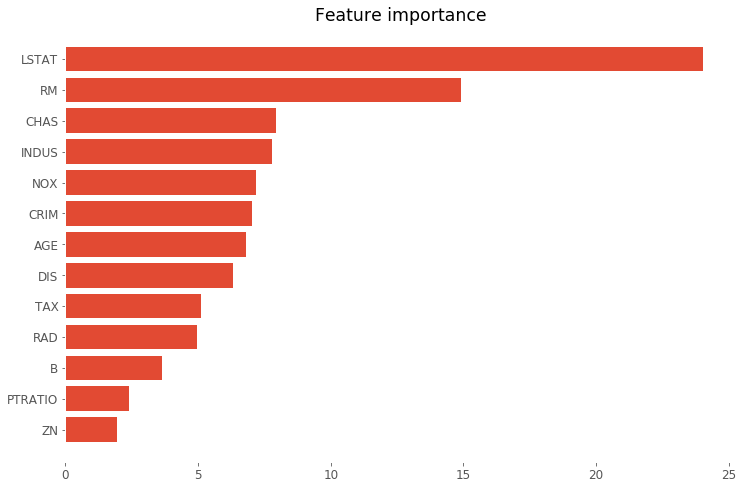

In [44]:
_ = plot_top_features(model, train_pool.get_feature_names(), min(20, df_train.shape[1]))

In [52]:
time_sum = 0
for i in range(0,n_time):
    start = time.time()
    cv_data = cv(params, train_pool, n_folds)
    end = time.time()
    time_sum += (end-start)
    
    
print('average cv time (CatBoost) = {0:.2f}'.format(time_sum / n_time))
print('RMSLE (CatBoost) = {0}'.format(cv_data['RMSE_test_avg'][-1]))

average cv time (CatBoost) = 63.47
RMSLE (CatBoost) = 0.159111227487


In [53]:
cat_grid_params = {
    'depth': [1, 2, 3],
    'learning_rate': [0.1, 0.05, 0.01],
    'iterations' : [100, 500, 1000]
}
best_params = catboost_param_tune(cat_grid_params, df_train, y_train, cat_indices, 5)
print(best_params)


Iteration with suspicious time 1.02 sec ignored in overall statistics.

Iteration with suspicious time 1.01 sec ignored in overall statistics.
{'learning_rate': 0.1, 'depth': 3, 'loss_function': 'RMSE', 'iterations': 1000, 'logging_level': 'Silent', 'custom_metric': 'RMSE'}


In [54]:
best_params['loss_function'] = 'RMSE'
best_params['custom_metric'] = 'RMSE'
best_params['calc_feature_importance'] = True

In [55]:
%%notify
model = CatBoostRegressor(**best_params)
cv_params = model.get_params()
del cv_params['calc_feature_importance']


av_time = 0
for i in range(0, n_time):
    t = time.time()
    cv_data = crossvaltest(cv_params, df_train, y_train, cat_indices, n_folds)
    av_time += time.time() - t

<IPython.core.display.Javascript object>

In [56]:
print('average cv time (CatBoost) = {0:.2f}'.format(av_time / n_time))
print('RMSLE (CatBoost) = {0}'.format(-cv_data)) 

average cv time (CatBoost) = 56.33
RMSLE (CatBoost) = 0.142323744564
